# Some regularizations and optimization algorithms on [Pima Indians Diabetes](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv) dataset
By [Zahra Taheri](https://github.com/zahta), November 26, 2020

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Set the seeds to ensure reproducibility
np.random.seed(1)
torch.manual_seed(1)

## Reading the dataset

In [2]:
data=pd.read_csv('diabetes.csv')
data.shape

(768, 9)

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Descriptive statistics and data visualizations

In [5]:
#Describe the dataset

data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
#Check the no. of unique items in each categorical column

data.select_dtypes('object').nunique()

Series([], dtype: float64)

In [7]:
# Percentage of missing data in each column

number_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64


### Correlations

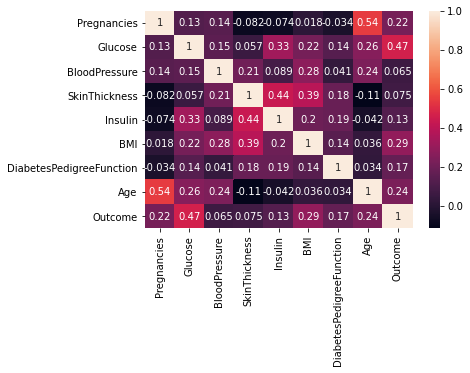

In [8]:
sns.heatmap(data.corr(), annot = True)

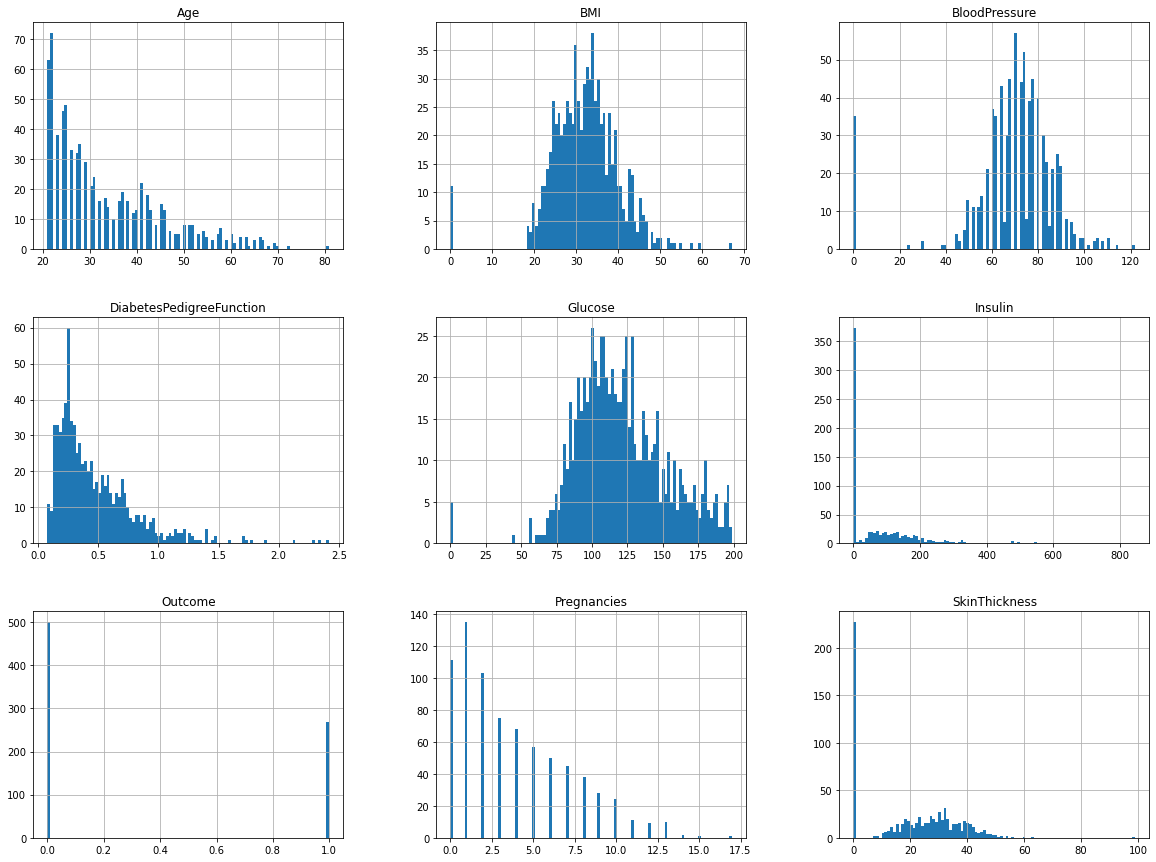

In [9]:
data.hist(bins=100, figsize=(20,15))

plt.show()

In [10]:
X=data.iloc[:,:8].values
y=data.iloc[:,8].values
print(data.shape)
print(X.shape)
print(y.shape)

(768, 9)
(768, 8)
(768,)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

train_data = std_scale.fit_transform(X_train)
test_data = std_scale.transform(X_test)

train_labels = y_train.reshape(-1,1)
test_labels = y_test.reshape(-1,1)

## Preparation of the dataset for PyTorch

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
tensor_x = torch.tensor(train_data, dtype=torch.float).to(device) # transform to torch tensor
tensor_x2 = torch.tensor(test_data, dtype=torch.float).to(device) 

In [16]:
tensor_y = torch.tensor(train_labels, dtype=torch.float).to(device)
tensor_y2 = torch.tensor(test_labels, dtype=torch.float).to(device)

In [17]:
# Normalizing the data

#print(tensor_x,tensor_x2)

#mean = torch.mean(tensor_x)
#std = torch.std(tensor_x)

#tensor_x = (tensor_x - mean) / std
#tensor_x2 = (tensor_x2 - mean) / std

## Building Feedforward Neural Networks with PyTorch

## Regularizations (Ensemble Methods)

- [Ensembles: the only (almost) free Lunch in Machine Learning](https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090)
    - Build optimal ensembles of neural networks with PyTorch and NumPy
    
    
- [Bagging and Dropout Learning](https://jrodthoughts.medium.com/bagging-and-dropout-learning-ae484023b0da)

### Dropout: Ensemble Method Interpretation
**Reference:** [Regularization by Sebastian Raschka](https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L10_regularization_slides.pdf)

- In DL, we typically don't do regular ensembling (majority vote over a large number of networks, bagging, etc.) because it is very expensive to fit neural nets.
- However, we know that the squared error for a prediction by a randomly selected model is larger than the squared error using an ensemble prediction (here, average over class probabilities).
- Now, in dropout, we have a different model for each minibatch. 
- Via the minibatch iterations, we essentially sample over $M=2^h$ models, where h is the number of hidden units.
- Restriction is that we have weight sharing over these models, which can be seen as a form of regularization.
- During "inference" we can then average over all these models (but this is very expensive). 
- However, using the last model after training and scaling the predictions by a factor 1/(1-p) approximates the geometric mean and is much cheaper (actually, it's exactly the geometric mean if we have a linear model).

### Dropout: More Practical Tips

- Don't use Dropout if your model does not overfit .
- However, in that case above, it is then recommended to increase the capacity to make it overfit, and then use dropout to be able to use a larger capacity model (but make it not overfit).



### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [75]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [76]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [77]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [78]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [79]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [80]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [81]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.5366622805595398. Accuracy: 77.0
Epoch: 500. Loss: 0.46224525570869446. Accuracy: 82.0
Epoch: 1000. Loss: 0.45986196398735046. Accuracy: 81.0
Epoch: 1500. Loss: 0.46127617359161377. Accuracy: 81.0
Epoch: 2000. Loss: 0.4732803702354431. Accuracy: 82.0
Epoch: 2500. Loss: 0.44946977496147156. Accuracy: 81.0
Epoch: 3000. Loss: 0.4708336591720581. Accuracy: 79.0
Epoch: 3500. Loss: 0.44731470942497253. Accuracy: 81.0
Epoch: 4000. Loss: 0.44218361377716064. Accuracy: 81.0
Epoch: 4500. Loss: 0.45056042075157166. Accuracy: 82.0


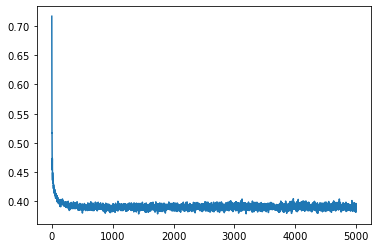

In [82]:
plt.plot(epoch_loss)

### Model B: 2 Hidden Layers Feedforward Neural Network

### Create model class

In [107]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(hidden_dim2, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear4(out)
        out = self.sigmoid(out)
        return out

In [108]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 50
hidden_dim2 = 100

In [109]:
model = FNN(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [110]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]             450
              ReLU-2                [-1, 1, 50]               0
            Linear-3               [-1, 1, 100]           5,100
           Dropout-4               [-1, 1, 100]               0
              ReLU-5               [-1, 1, 100]               0
            Linear-6                 [-1, 1, 1]             101
           Sigmoid-7                 [-1, 1, 1]               0
Total params: 5,651
Trainable params: 5,651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [111]:
criterion = nn.BCELoss()

learning_rate = 0.01
LAMBDA = 0.009
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [112]:
# Train the model

num_epochs = 10000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 1000 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.6810814738273621. Accuracy: 63.0
Epoch: 1000. Loss: 0.47786954045295715. Accuracy: 79.0
Epoch: 2000. Loss: 0.4346664249897003. Accuracy: 82.0
Epoch: 3000. Loss: 0.4311755895614624. Accuracy: 80.0
Epoch: 4000. Loss: 0.42886853218078613. Accuracy: 82.0
Epoch: 5000. Loss: 0.4618012607097626. Accuracy: 82.0
Epoch: 6000. Loss: 0.44667986035346985. Accuracy: 81.0
Epoch: 7000. Loss: 0.4513941705226898. Accuracy: 79.0
Epoch: 8000. Loss: 0.44242632389068604. Accuracy: 81.0
Epoch: 9000. Loss: 0.44299569725990295. Accuracy: 81.0


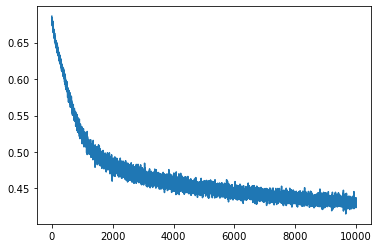

In [113]:
plt.plot(epoch_loss)

## **Optimization:** Different optimizers and batch normalization

## 1. SGD

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [114]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [115]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [116]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [117]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [118]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [119]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [120]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.6263636946678162. Accuracy: 73.0
Epoch: 500. Loss: 0.43557703495025635. Accuracy: 83.0
Epoch: 1000. Loss: 0.43466341495513916. Accuracy: 80.0
Epoch: 1500. Loss: 0.4574018120765686. Accuracy: 82.0
Epoch: 2000. Loss: 0.4474860727787018. Accuracy: 81.0
Epoch: 2500. Loss: 0.45311251282691956. Accuracy: 81.0
Epoch: 3000. Loss: 0.4561103582382202. Accuracy: 81.0
Epoch: 3500. Loss: 0.43968328833580017. Accuracy: 81.0
Epoch: 4000. Loss: 0.4570644795894623. Accuracy: 80.0
Epoch: 4500. Loss: 0.4597553014755249. Accuracy: 81.0


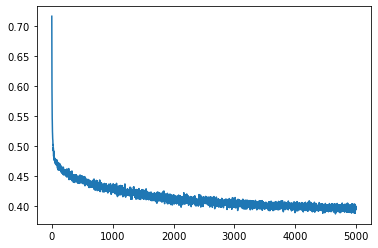

In [121]:
plt.plot(epoch_loss)

## 2. SGD Momentum

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [122]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [123]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [124]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [125]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [126]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.8)

In [127]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [128]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.6517653465270996. Accuracy: 71.0
Epoch: 500. Loss: 0.4478762745857239. Accuracy: 82.0
Epoch: 1000. Loss: 0.46376264095306396. Accuracy: 81.0
Epoch: 1500. Loss: 0.44708380103111267. Accuracy: 82.0
Epoch: 2000. Loss: 0.4432355761528015. Accuracy: 79.0
Epoch: 2500. Loss: 0.45371371507644653. Accuracy: 82.0
Epoch: 3000. Loss: 0.45403093099594116. Accuracy: 83.0
Epoch: 3500. Loss: 0.46377667784690857. Accuracy: 82.0
Epoch: 4000. Loss: 0.46613603830337524. Accuracy: 79.0
Epoch: 4500. Loss: 0.45843619108200073. Accuracy: 80.0


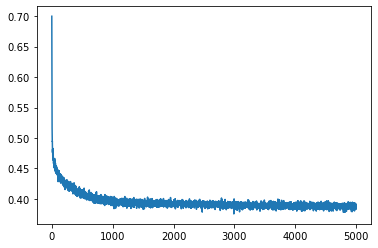

In [129]:
plt.plot(epoch_loss)

## 3. SGD Nesterov

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [130]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [131]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [132]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [133]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [134]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.8, nesterov=True)

In [135]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [136]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.6343744993209839. Accuracy: 71.0
Epoch: 500. Loss: 0.45224830508232117. Accuracy: 81.0
Epoch: 1000. Loss: 0.43933847546577454. Accuracy: 83.0
Epoch: 1500. Loss: 0.4569447636604309. Accuracy: 82.0
Epoch: 2000. Loss: 0.4660406708717346. Accuracy: 79.0
Epoch: 2500. Loss: 0.45325037837028503. Accuracy: 81.0
Epoch: 3000. Loss: 0.4395796060562134. Accuracy: 81.0
Epoch: 3500. Loss: 0.4467664957046509. Accuracy: 81.0
Epoch: 4000. Loss: 0.46518945693969727. Accuracy: 79.0
Epoch: 4500. Loss: 0.4424806535243988. Accuracy: 82.0


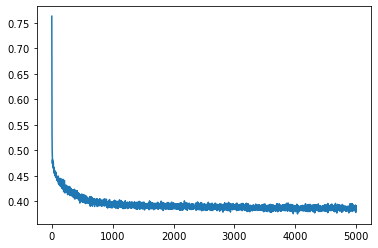

In [137]:
plt.plot(epoch_loss)

## 4. Adam

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [138]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [139]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [140]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [141]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [142]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [143]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [144]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.7305088043212891. Accuracy: 74.0
Epoch: 500. Loss: 0.4380885064601898. Accuracy: 81.0
Epoch: 1000. Loss: 0.4324254095554352. Accuracy: 79.0
Epoch: 1500. Loss: 0.4698551297187805. Accuracy: 81.0
Epoch: 2000. Loss: 0.45652613043785095. Accuracy: 81.0
Epoch: 2500. Loss: 0.44767796993255615. Accuracy: 79.0
Epoch: 3000. Loss: 0.4508647322654724. Accuracy: 81.0
Epoch: 3500. Loss: 0.458648145198822. Accuracy: 80.0
Epoch: 4000. Loss: 0.45852547883987427. Accuracy: 82.0
Epoch: 4500. Loss: 0.4711846113204956. Accuracy: 79.0


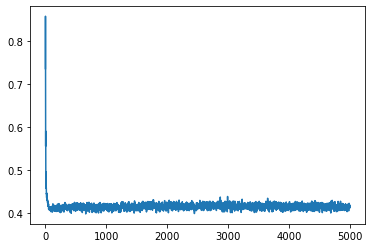

In [145]:
plt.plot(epoch_loss)

## 5. Adagrad

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [146]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [147]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [148]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [149]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [150]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [151]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [152]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.6156861782073975. Accuracy: 78.0
Epoch: 500. Loss: 0.458961546421051. Accuracy: 80.0
Epoch: 1000. Loss: 0.4466301500797272. Accuracy: 83.0
Epoch: 1500. Loss: 0.4429565668106079. Accuracy: 81.0
Epoch: 2000. Loss: 0.464893639087677. Accuracy: 81.0
Epoch: 2500. Loss: 0.4646756052970886. Accuracy: 82.0
Epoch: 3000. Loss: 0.46783125400543213. Accuracy: 81.0
Epoch: 3500. Loss: 0.4490252435207367. Accuracy: 80.0
Epoch: 4000. Loss: 0.4568312466144562. Accuracy: 81.0
Epoch: 4500. Loss: 0.4508931040763855. Accuracy: 82.0


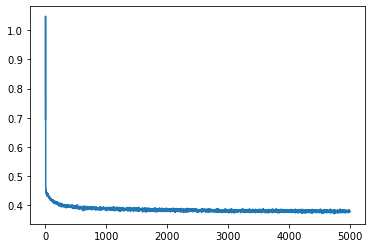

In [153]:
plt.plot(epoch_loss)

## 6. Adadelta

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [154]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [155]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [156]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [157]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [158]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [159]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [160]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.7609028220176697. Accuracy: 36.0
Epoch: 500. Loss: 0.4329078495502472. Accuracy: 82.0
Epoch: 1000. Loss: 0.4331403970718384. Accuracy: 79.0
Epoch: 1500. Loss: 0.4249666929244995. Accuracy: 82.0
Epoch: 2000. Loss: 0.4477139711380005. Accuracy: 82.0
Epoch: 2500. Loss: 0.43603649735450745. Accuracy: 81.0
Epoch: 3000. Loss: 0.4389086663722992. Accuracy: 82.0
Epoch: 3500. Loss: 0.43926575779914856. Accuracy: 81.0
Epoch: 4000. Loss: 0.44071123003959656. Accuracy: 81.0
Epoch: 4500. Loss: 0.44395461678504944. Accuracy: 82.0


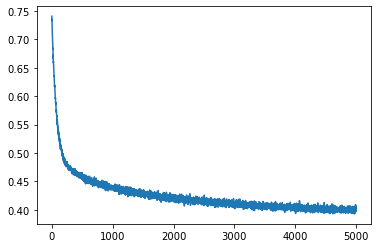

In [161]:
plt.plot(epoch_loss)

## 7. Adamax

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [162]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [163]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [164]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [165]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [166]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [167]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [168]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.49955952167510986. Accuracy: 77.0
Epoch: 500. Loss: 0.46133601665496826. Accuracy: 81.0
Epoch: 1000. Loss: 0.45412302017211914. Accuracy: 79.0
Epoch: 1500. Loss: 0.46771398186683655. Accuracy: 79.0
Epoch: 2000. Loss: 0.4591347873210907. Accuracy: 81.0
Epoch: 2500. Loss: 0.4525974690914154. Accuracy: 82.0
Epoch: 3000. Loss: 0.45025911927223206. Accuracy: 81.0
Epoch: 3500. Loss: 0.43255650997161865. Accuracy: 83.0
Epoch: 4000. Loss: 0.4689691662788391. Accuracy: 81.0
Epoch: 4500. Loss: 0.43324536085128784. Accuracy: 81.0


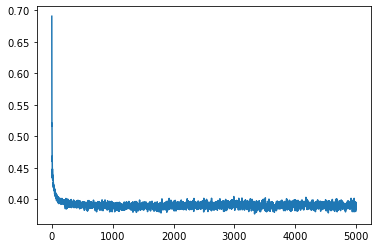

In [169]:
plt.plot(epoch_loss)

## 8. RMSProp

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [170]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [171]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [172]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [173]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           4,500
           Dropout-2               [-1, 1, 500]               0
              ReLU-3               [-1, 1, 500]               0
            Linear-4                 [-1, 1, 1]             501
           Sigmoid-5                 [-1, 1, 1]               0
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [174]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

In [175]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [176]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 24.56024932861328. Accuracy: 69.0
Epoch: 500. Loss: 0.47200101613998413. Accuracy: 79.0
Epoch: 1000. Loss: 0.5050909519195557. Accuracy: 79.0
Epoch: 1500. Loss: 0.4552174210548401. Accuracy: 81.0
Epoch: 2000. Loss: 0.46157118678092957. Accuracy: 78.0
Epoch: 2500. Loss: 0.43608906865119934. Accuracy: 79.0
Epoch: 3000. Loss: 0.831511378288269. Accuracy: 67.0
Epoch: 3500. Loss: 0.7079839110374451. Accuracy: 71.0
Epoch: 4000. Loss: 0.4484008252620697. Accuracy: 81.0
Epoch: 4500. Loss: 0.4348273277282715. Accuracy: 80.0


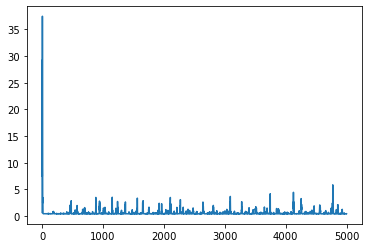

In [177]:
plt.plot(epoch_loss)

## Batch normalization

### Model A: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [28]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.BatchNorm1d1=nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(0.4)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, output_dim)
        self.BatchNorm1d2=nn.BatchNorm1d(output_dim)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.BatchNorm1d1(out)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.BatchNorm1d2(out)
        out = self.sigmoid(out)
        return out

In [29]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500

In [30]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [31]:
#summary(model, (1,tensor_x.shape[1]))

In [32]:
criterion = nn.BCELoss()

learning_rate = 0.05
LAMBDA = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.8, nesterov=True)

In [33]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [34]:
# Train the model

num_epochs = 5000
epoch_loss = []
X = tensor_x
y = tensor_y
X_test = tensor_x2
y_test = tensor_y2

for epoch in range(num_epochs):
        # Forward pass to get output/logits
        outputs = model(X)
        
        # Calculate Loss
        loss = criterion(outputs, y)
        
        '''
        Save loss to draw loss curve
        '''
        epoch_loss.append(loss)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
             
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    
        # Testing the model
        if epoch % 500 == 0:
            # Forward pass to get output/logits
            outputs = model(X_test)
            loss_t = criterion(outputs, y_test)
            
            # Print Loss
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss_t.data, accuracy(outputs, y_test)))
            

Epoch: 0. Loss: 0.5521842241287231. Accuracy: 74.0
Epoch: 500. Loss: 0.5173280239105225. Accuracy: 79.0
Epoch: 1000. Loss: 0.6293770670890808. Accuracy: 73.0
Epoch: 1500. Loss: 0.5981286764144897. Accuracy: 79.0
Epoch: 2000. Loss: 0.6007148623466492. Accuracy: 77.0
Epoch: 2500. Loss: 0.6430805921554565. Accuracy: 78.0
Epoch: 3000. Loss: 0.6051543354988098. Accuracy: 76.0
Epoch: 3500. Loss: 0.840488851070404. Accuracy: 69.0
Epoch: 4000. Loss: 0.5985617637634277. Accuracy: 78.0
Epoch: 4500. Loss: 0.5723690390586853. Accuracy: 79.0


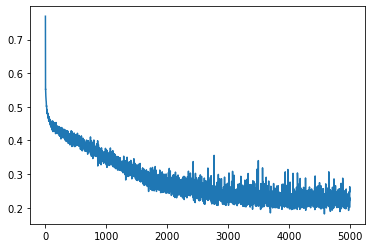

In [35]:
plt.plot(epoch_loss)

## Results of regularizations

| Model Name                    | Test Accuracy | Test Accuracy(Dropout) | 
|--------------------------------|----------|----------|
| Model A |  81  |  82  |
| Model B |  81  |  81  |

## Results of optimizations (Test accuracy)
- With dropouts from the regularization part

| Optimizer                    | Model A |
|--------------------------------|----------|
| SGD |  81.0  |
| SGD Momentum |  80.0  | 
| SGD Nesterov |  82.0  | 
| Adam |  79.0  |
| Adagrad |  82.0 |
| Adadelta |  82.0 | 
| Adamax |  81.0 |
| RMSProp | 80.0  | 


### Batch normalozation
- With dropouts from the regularization part
- We employed one of the best optimizers for the model from the previous table

| Model Name | Optimizer| Test Accuracy |
|------------|----------|----------|
| Model B |  SGD Nesterov  |   79.0 | 
